In [1]:
import configargparse
import numpy as np
from cryoem.projections import *
import numpy as np
import os, sys
import scipy.io as sio
sys.path.append(os.getcwd())
import mrcfile
import astra
import pathlib
import h5py
from cryoem.rotation_matrices import RotationMatrix
from tensorflow_graphics.geometry.transformation import quaternion
from cryoem.conversions import quaternion2euler
import pickle
import os
import h5py
import numpy as np   

import sys
from cryoem.projections import RotationMatrix
from cryoem.conversions import euler2quaternion
from cryoem.plots import plot_detector_pixels_with_protein, plot_images, plot_rays, plot_angles_histogram, plot_quaternions_histogram, plot_rotvec, plot_polar_plot, plot_projection, plot_projections

First step:
Load 3d data and visualize it

In [2]:
import nglview as nv
PROTEIN = "5j0n"
print(f"{PROTEIN}.mrc")
view_density_map = nv.show_file(f"{PROTEIN}.mrc")
view_density_map

5j0n.mrc


NGLWidget()

In [5]:
file_name = './data/5j0n.mrc'

In [93]:
with mrcfile.open(file_name) as mrcVol:
    Vol      = np.array(mrcVol.data) 
    ProjSize = int(np.sqrt(np.sum(np.square(Vol.shape))))
print(Vol.shape)

(69, 57, 75)


In [94]:
#Then load the angle data:
file_angle = 'notebooks/0-data-preparation/angle_data.pkl'
with open(file_angle, 'rb') as f:
    angles2 = pickle.load(f)
print(angles2[:4])

[[0.        0.        0.       ]
 [1.8860662 2.0739784 3.6501303]
 [3.948796  1.4204998 2.6239626]
 [1.0760686 0.9697671 3.369385 ]]


In [95]:
#Here we resive the volumn to be 1/6
from scipy.ndimage import zoom
Vol = zoom(Vol, (15/69, 15/57, 15/75))
print(Vol.shape)
ProjSize = int(np.sqrt(np.sum(np.square(Vol.shape))))
print(ProjSize)

(15, 15, 15)
25


In [85]:
Projections = generate_projections_ASTRA(Vol, angles2, ProjSize, BatchSizeAstra = "None")
dtype = np.float32
Projections = np.array(Projections, dtype=dtype)

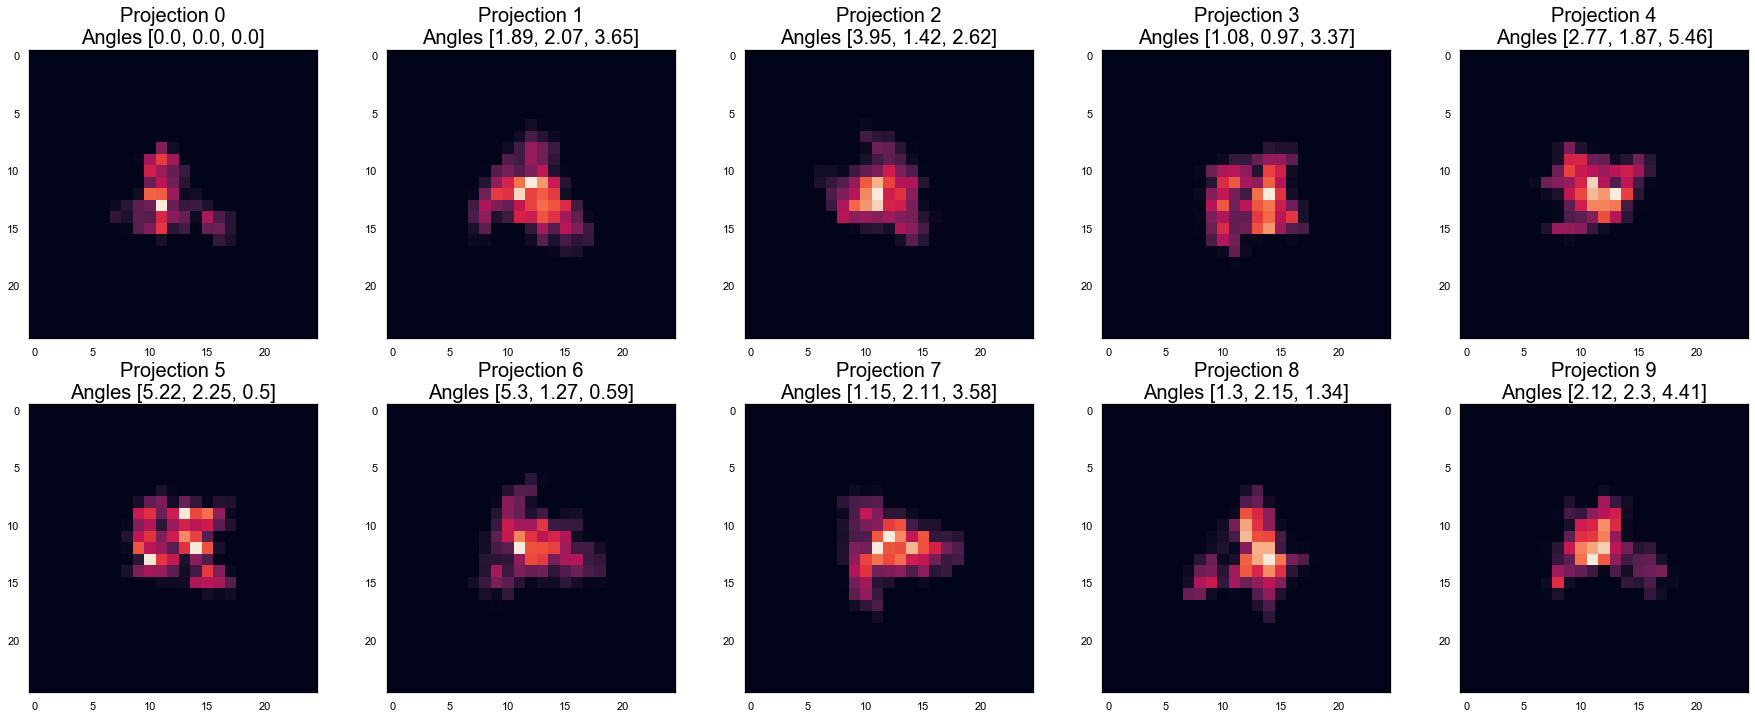

In [86]:
pids = range(10)
plot_projections(Projections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

So by putting Vol, angle in functino: <br>
generate_projections_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None") <br>
, we can get AjS

In [87]:
BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")

In [88]:
print(BP_data.shape)
print(BP_data[0].shape)
print(Projections[0].shape)
print(np.sum(BP_data[0] - Projections[0]))

(25, 25, 25)
(25, 25)
(25, 25)
7.31466


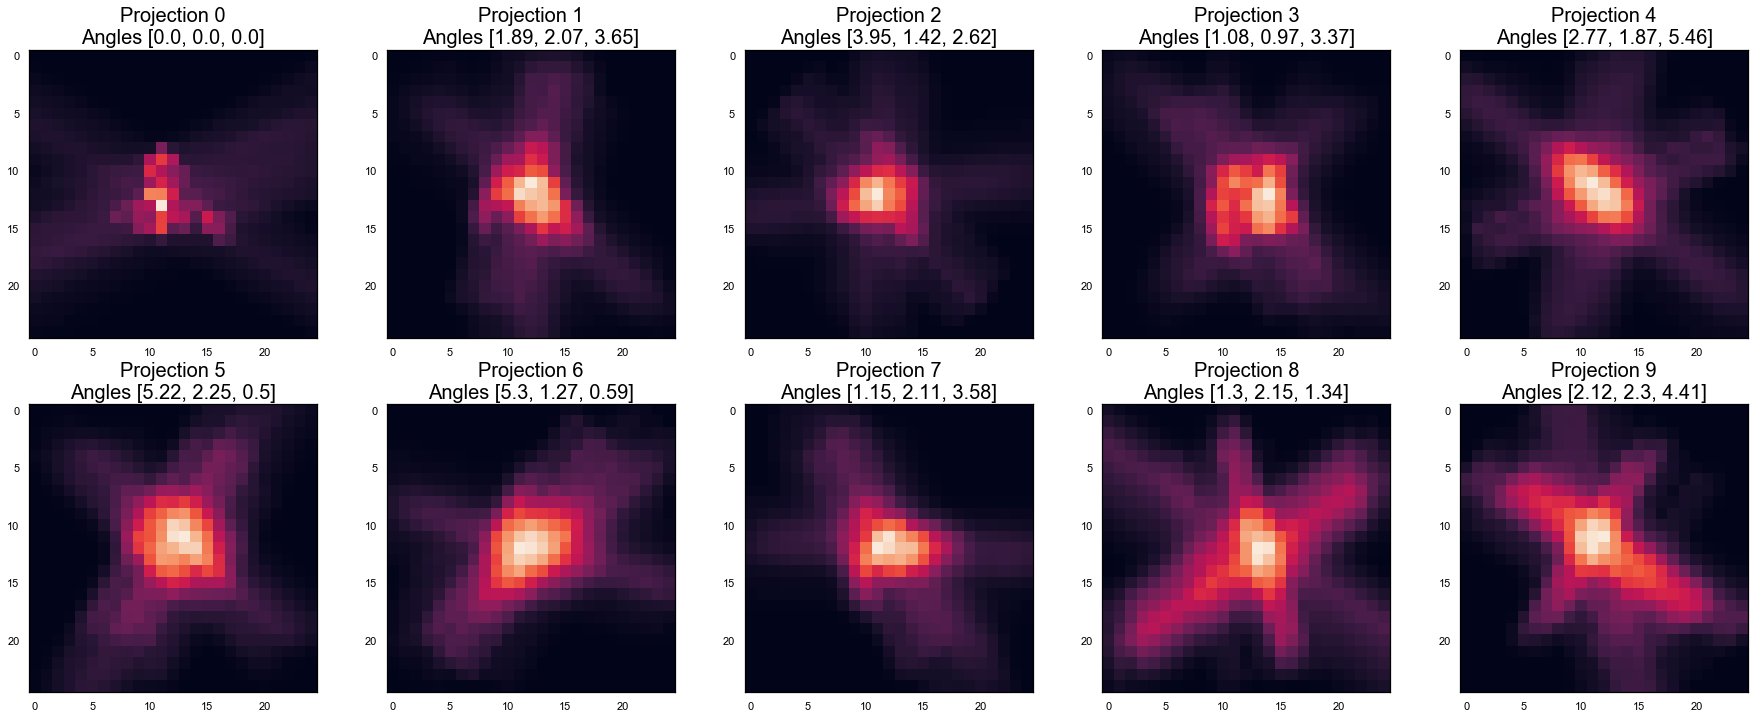

In [89]:
CheckProjections = generate_projections_ASTRA(BP_data, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [189]:
class PCA_3d_Recon():
    def __init__(self, ProjSize, num_image, n_component):
        #init
        self.ProjSize  = ProjSize
        self.num_image = num_image
        self.n_component = n_component
        
        self.mu = np.abs(np.random.randn(ProjSize, ProjSize, ProjSize))
        self.sigma = np.ones(self.num_image) * 0.1
        
        self.ro = np.abs(np.random.randn(num_image, n_component))
        self.BigSigma = np.abs(np.ones((self.num_image, self.n_component, self.n_component )))
        #print('original ro', self.ro[:5])
    def fit(self, Imgages, Angles):
        print('start fitting')
        self.Plot_mu_by_projection(Angles)
        for i in range(100):

            self.Expectation(Imgages, Angles)
            self.Maximization(Imgages, Angles)
            self.Q_(Imgages, Angles)
            if i % 10 == 9:
                print(i)
                self.Plot_mu_by_projection(Angles)
        pass
    
    def Expectation(self, Imgages, Angles):
        """
        First, get all projection information
        
        ro_j = 1/sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1)(Au)^TI
        
        #We expect to get a n_image x n_component matrix for ro
        
        BigSigma = I - 1 / sigma^2 * (I + 1/sigma^2 * (Au)^TAu)^(-1) (Au)^TAu
        """
        
        self.Au_s(Angles)
        ro = [] #For n image, we have n z.
        for j in range(self.num_image):
            Ij = Imgages[j].reshape(-1, 1, order = 'F')
            roj = 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j])@(self.Aus[j].T @ Ij) 
            ro.append(roj[0][0])
        
        self.ro = np.array(ro).reshape(-1, self.n_component)
        
        AllBigSigma = np.zeros((self.num_image, self.n_component, self.n_component ))
        for j in range(self.num_image):
            BigSigma = np.eye(self.n_component) - 1 / self.sigma[j]**2 * np.linalg.inv(np.eye(self.n_component) + 1 / self.sigma[j]**2 * self.Aus[j].T @ self.Aus[j]) @ self.Aus[j].T @ self.Aus[j]
            roj = self.ro[j].reshape(self.n_component , 1)
            BigSigma = BigSigma + roj@roj.T
            AllBigSigma[j] = BigSigma
            #print('BigSigma', BigSigma)
        self.BigSigma = AllBigSigma
        #print('updated BigSigma',self.BigSigma[:5])
        #print(self.BigSigma.shape)
        #print('updated ro', self.ro[:5])
        
    def Maximization(self, Images, Angles):
        
        lr = 1e-4
        for i in range(10):
            DeltaMu = self.Delta_mu( Images, Angles)
            #print('mu mean',np.mean(np.abs(self.mu)))
            #print('delta mu mean',np.mean(np.abs(DeltaMu)))
            self.mu = self.mu - lr * DeltaMu
            #print('min mu', np.min(self.mu))
            self.Au_s(Angles)
            #print('self.mu', np.sum(self.mu))
            #self.Q_(Images, Angles)
        #print(self.mu)
        pass
    
    def Delta_mu(self, Images, Angles):
        """
        right_term = 
        delta mu = sum(1 / sigma_j**2 * () )
        """
        sum_all = []
        for j in range(self.num_image):
            temp = 0
            right_term = 0

            for i in range(self.n_component):
                right_term += right_term + self.Aus[j]*self.BigSigma[j][i][0]
            
            
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left_term = Ij* self.ro[j][self.n_component-1]
            temp = left_term - right_term
            temp = temp.reshape(self.ProjSize, self.ProjSize, order = 'F')
            
            sum_all.append( (1 / self.sigma[j]**2 * temp).tolist() )
        
        sum_all = np.array(sum_all)
        
        
        
        
        DeltaMu = back_projections_ASTRA( sum_all, Angles, self.ProjSize, BatchSizeAstra = "None")
        return DeltaMu
    
    def update_sigma(self):
        """
        
        """
        pass
    
    def Au_s(self, Angles):
        """
        By computing Au, given a angle a, we use
        Projections = generate_projectionaefmpss_ASTRA(Vol, angles2[:10], ProjSize, BatchSizeAstra = "None")
        to generate lots of projections simultaneously
        """
        Projections = generate_projections_ASTRA(self.mu, Angles, self.ProjSize, BatchSizeAstra = "None")
        #print(Projections.shape)
        check_image = Projections[0].reshape(-1, 1, order = 'F')
        self.Aus =  Projections.reshape(Projections.shape[0], -1 , 1, order = 'F') #with fortrain - like order
        #print('check_Aus', check_image)
    def Au(self, angle, vol):
        """
        Only compute one Au
        """
        Single_Projections = generate_projections_ASTRA(vol, angle.reshape(1,3 ), self.ProjSize, BatchSizeAstra = "None")
        #print(Single_Projections.shape)
        return Single_Projections
    def AtI(self, Imgage, Angle): #only input one image, one angle
        """
        By computing AtI, we use backprojection algorithm
        BP_data = back_projections_ASTRA(Projections[:4], angles2[:4], ProjSize, BatchSizeAstra = "None")
        But since it can't compute all bps at the same time, we comute it one by one
        """
        Imgage = Imgage.reshape(1, Imgage.shape[0], Imgage.shape[1], order = 'F')
        Angle = Angle.reshape(1, Angle.shape[0])
        Bp = back_projections_ASTRA(Imgage, Angle, self.ProjSize, BatchSizeAstra = "None")
        #print(Bp.shape)
        return Bp
    
    def Q_(self,Images,  Angles, ):
        """
        might > 0 since IjT * Ij is droped.
        """
        sum_ = 0 
        for j in range(self.num_image):
            #print(j)
            Ij = Images[j].reshape(-1, 1, order = 'F')
            left = Ij.T @ self.Au(Angles[j], self.mu).reshape(-1, 1, order = 'F') * self.ro[j]

            Aju =  self.Aus[j]
            right = Aju.T @ Aju *self.BigSigma[0][0] +1/2 * Aju.T @ Aju * self.BigSigma[0][0]
            
            sum_ += 1/ self.sigma[j]**2 *(left - right)
        print('Q', sum_[0][0])
        try:
            print('delta Q', sum_[0][0]- self.Q[0][0])
        except:
            pass
        self.Q = sum_
        #pass
    def Plot_mu_by_projection(self, Angles):
        #print(P3R.mu)
        curremt_mu = self.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
        CheckProjections = generate_projections_ASTRA(curremt_mu, Angles[:10], ProjSize, BatchSizeAstra = "None")
        pids = range(10)
        plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , Angles[pid]))}' for pid in pids], nrows=2, ncols=5)


start fitting


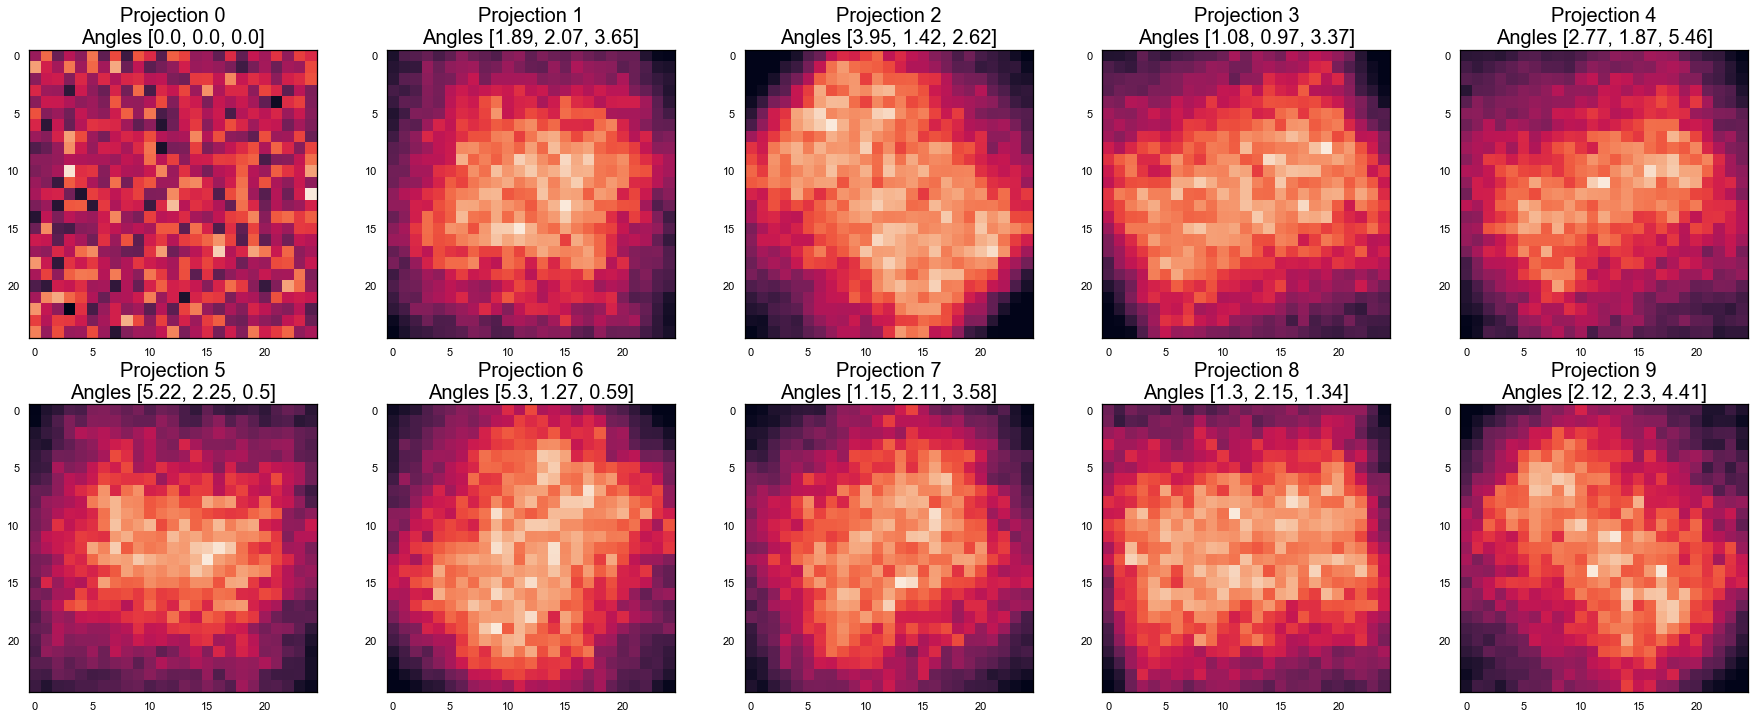

Q 42490.248192270854
Q 44269.77191021097
delta Q 1779.5237179401156
Q 42512.01010445341
delta Q -1757.76180575756
Q 43608.179533947936
delta Q 1096.1694294945264
Q 44457.15625254249
delta Q 848.976718594553
Q 42633.461866929436
delta Q -1823.6943856130529
Q 45475.093776814334
delta Q 2841.631909884898
Q 42435.08304821205
delta Q -3040.010728602283
Q 42740.42625022649
delta Q 305.34320201443916
Q 42815.31446636635
delta Q 74.88821613985783
9


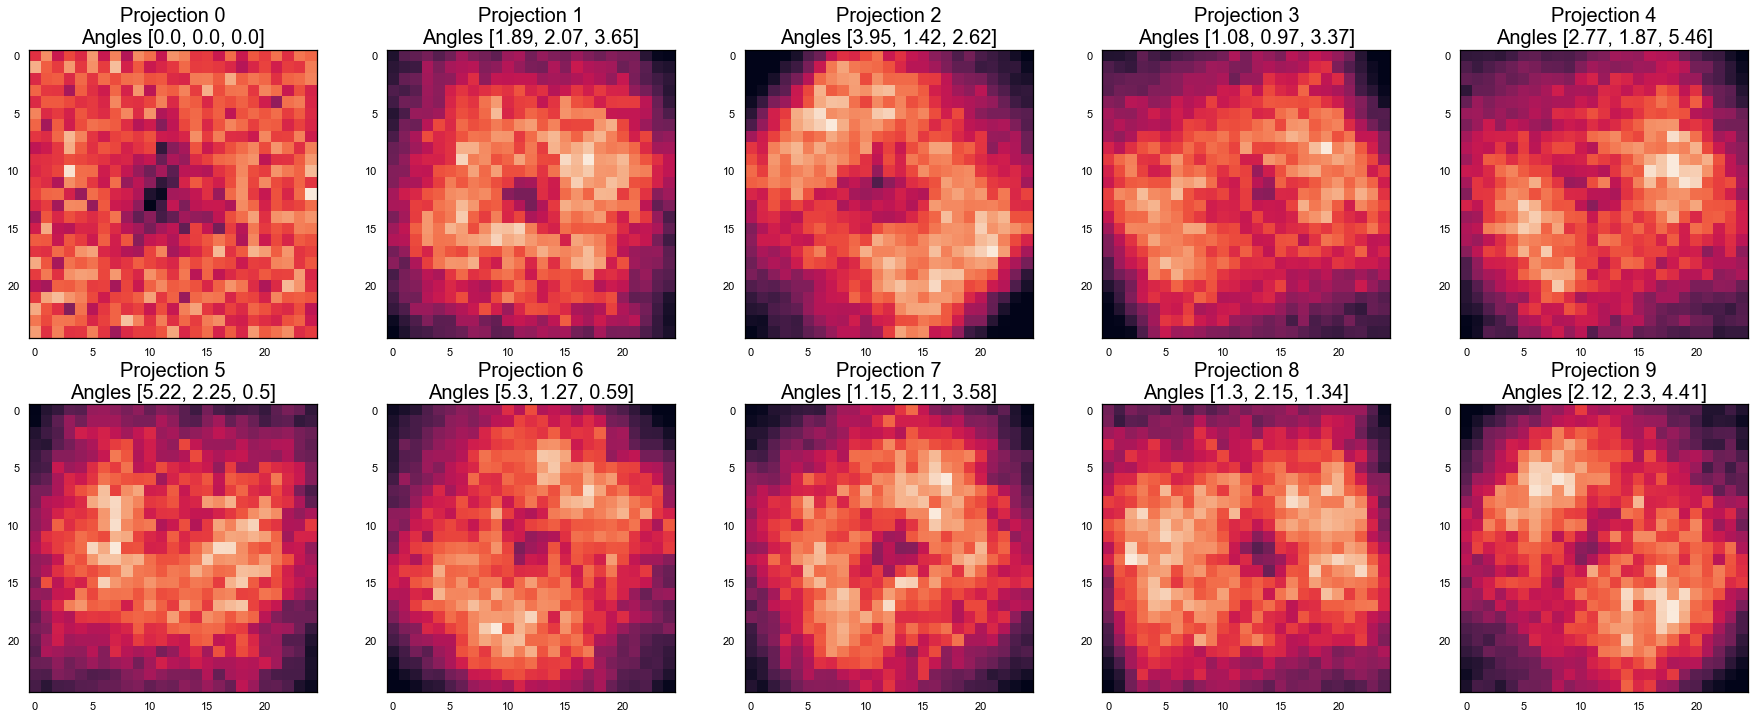

Q 40072.791482912064
delta Q -2742.5229834542843
Q 37505.468525422744
delta Q -2567.3229574893194
Q 35838.94616129582
delta Q -1666.5223641269258


KeyboardInterrupt: 

In [190]:
_, num_image , n_component = 116, 500 , 1
angles2 = angles2[:500]
Projections = Projections[:500]
P3R = PCA_3d_Recon(ProjSize, num_image, n_component)
#P3R.Au_s(angles2)
#P3R.AtI(Projections[4], angles2[4])
#print('Projections', Projections.shape)
#P3R.Q_(Projections, angles2)
#print('brfore exp')
#P3R.Expectation(Projections, angles2)
#print('after exp')
P3R.fit(Projections, angles2)


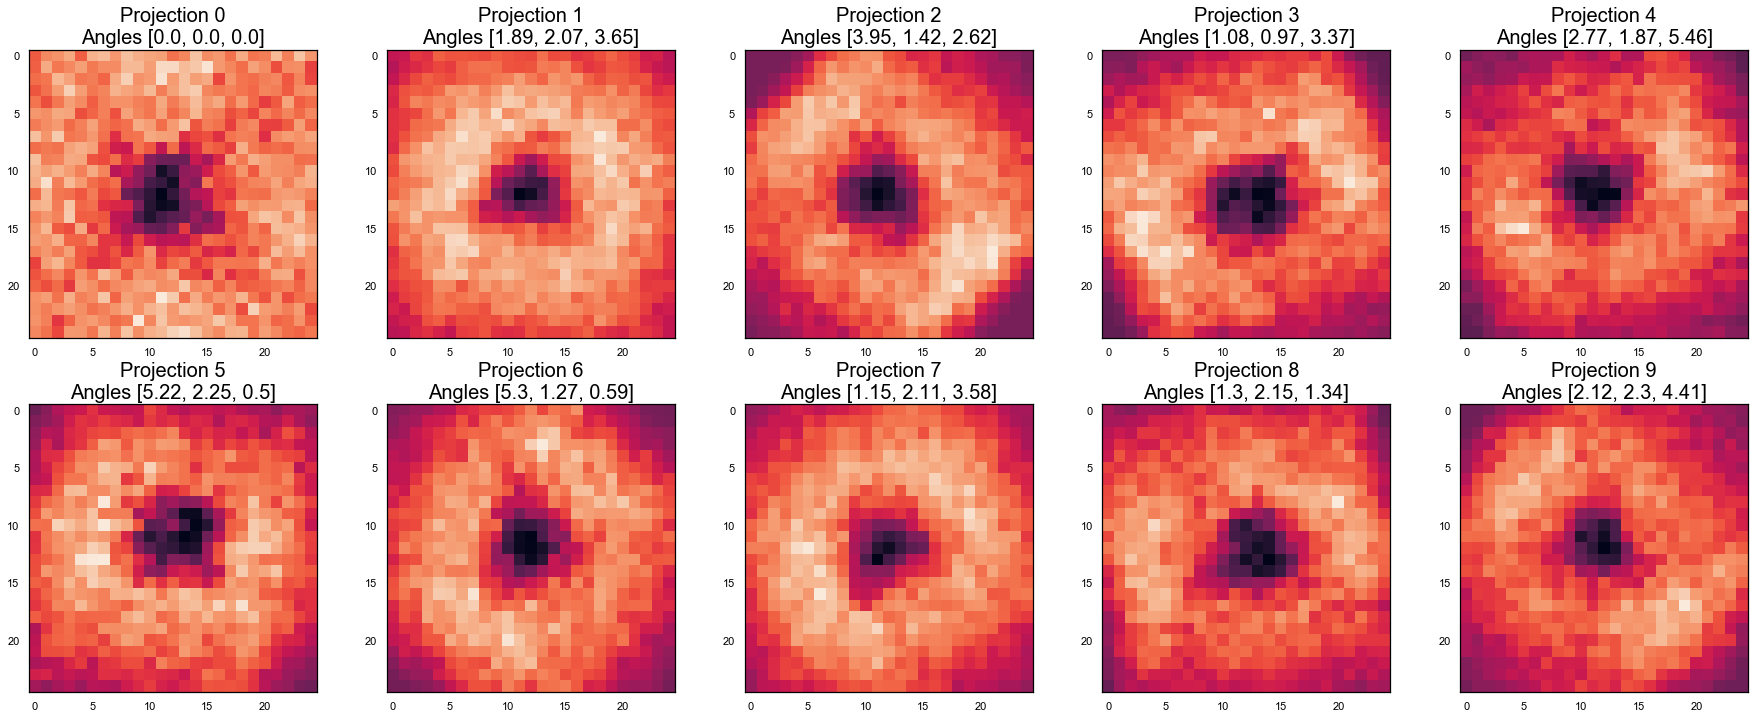

In [186]:
#print(P3R.mu)
curremt_mu = P3R.mu.reshape(ProjSize,ProjSize,ProjSize, order = 'F' )
CheckProjections = generate_projections_ASTRA(curremt_mu, angles2[:10], ProjSize, BatchSizeAstra = "None")
pids = range(10)
plot_projections(CheckProjections[pids], [f'Projection {pid}\nAngles {list(map(lambda x: round(x,2) , angles2[pid]))}' for pid in pids], nrows=2, ncols=5)

In [187]:
print(CheckProjections[0])

[[ 15.499003    19.677141    20.568277    22.810844    15.767727
   23.87491     24.780554    21.135029    25.204435    23.314432
   22.509304    22.055605    17.435602    19.401617    25.579529
   20.055473    21.151707    17.488304    23.196426    17.675516
   18.499561    24.596197    18.839827    25.618698    21.038998  ]
 [ 15.914207    22.923012    18.041485    19.683588    21.855679
   18.165394    19.786488    19.853859    24.48368     24.568735
   21.618454    28.199244    27.999866    24.773966    25.918856
   29.257921    21.182535    19.30833     16.965878    22.14241
   19.994558    14.297252    19.779175    20.23424     13.164822  ]
 [ 17.19006     17.794092    24.26931     22.210556    17.819561
   18.582348    16.27933     22.9717      27.030226    20.527514
   21.26152     28.94296     21.352695    25.08545     21.903236
   23.055555    13.72655     20.58824     17.636814    17.146729
   18.677029    19.563694    15.255205    18.998438    13.571378  ]
 [ 15.061124    1